In [1]:
from THB.space import Space
from THB.datastructures import *
from THB.JAX import *
from THB.core import *
from THB.funcs import *
from THB.utils import *

import numpy as np
from jax import grad, jit, value_and_grad
import jax.numpy as jnp
import optax
from tqdm import tqdm

In [2]:
bs1 = BSpline(knotvector=np.array([0, 0, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1, 1]), degree=2)
bs2 = BSpline(knotvector=np.array([0, 0, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1, 1]), degree=2)

tp = TensorProduct([bs1, bs2])

In [3]:
h_space = Space(tensor_product=tp, num_levels=3)
h_space.build_hierarchy_from_domain_sequence()
ac_cells = compute_active_cells_active_supp(h_space.cells, h_space.fns, h_space.degrees)
fn_coeffs = compute_refinement_operators(h_space.fns, h_space.Coeff, h_space.degrees)

  0%|          | 0/10000 [00:00<?, ?it/s]

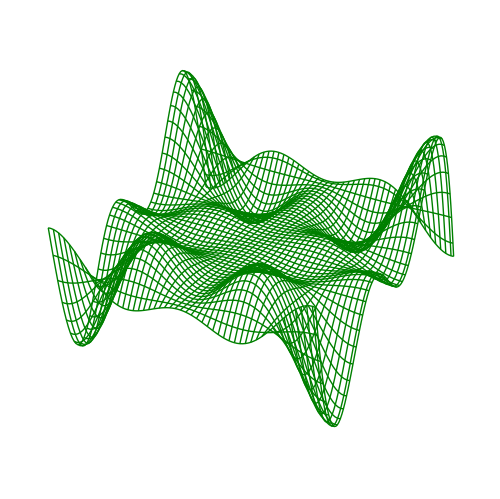

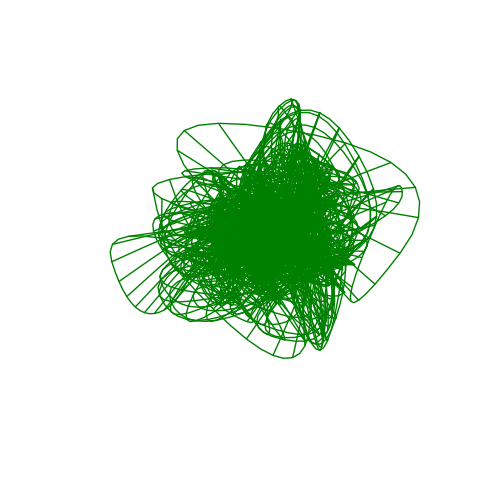

In [4]:
parameters = generate_parametric_coordinates((100, 100))
ac_spans = compute_active_span(parameters, h_space.knotvectors, h_space.cells, h_space.degrees, h_space.sh_fns)
PHI, num_supp = compute_basis_fns_tp_parallel(parameters, ac_spans, ac_cells, fn_coeffs, h_space.sh_fns, h_space.knotvectors, h_space.degrees)

CP = ControlPoints(h_space)

ctrl_pts = {lev: np.zeros((*h_space.sh_fns[lev], 3)) for lev in range(h_space.num_levels)}
ctrl_pts[0] = np.random.randn(*ctrl_pts[0].shape)

ctrl_pts, Jm, PHI, segment_ids, num_pts = prepare_data_for_evaluation_jax(PHI, ac_spans, num_supp, ctrl_pts, ac_cells, h_space.sh_fns)

target = np.loadtxt('surfaces/xysincos/xysincos.xyz', delimiter=' ')
target_plot = THB_plot('surfaces/xysincos', 'target')
target_plot.add_3Daxis('wireframe')
target_plot.plot_3D_wireframe_surface('wireframe', target, (100, 100))

out = np.array(Evaluate_JAX(ctrl_pts, Jm, PHI, segment_ids, num_pts))
fitplot = THB_plot('surfaces/xysincos', 'final_surface')
fitplot.add_3Daxis('final surface')
fitplot.plot_3D_wireframe_surface('final surface', out, (100, 100))

n_iter = 10000
lr = 0.1
pbar = tqdm(range(n_iter))
solver = optax.adam(learning_rate=lr)
opt_state = solver.init(ctrl_pts)

In [5]:
def loss_fn(ctrl_pts, Jm, PHI, segment_ids, num_pts, target):
    out = Evaluate_JAX(ctrl_pts, Jm, PHI, segment_ids, num_pts)
    loss = jnp.mean((out-target)**2)
    return loss

loss_fn_jit = jit(loss_fn, static_argnums=(4,))
loss_fn_grad = jit(grad(loss_fn, argnums=0), static_argnums=(4,))

for i in pbar:
    loss = loss_fn_jit(ctrl_pts, Jm, PHI, segment_ids, num_pts, target)
    grads = loss_fn_grad(ctrl_pts, Jm, PHI, segment_ids, num_pts, target)
    updates, opt_state = solver.update(grads, opt_state)
    ctrl_pts = optax.apply_updates(ctrl_pts, updates)

100%|██████████| 10000/10000 [00:07<00:00, 1260.55it/s]


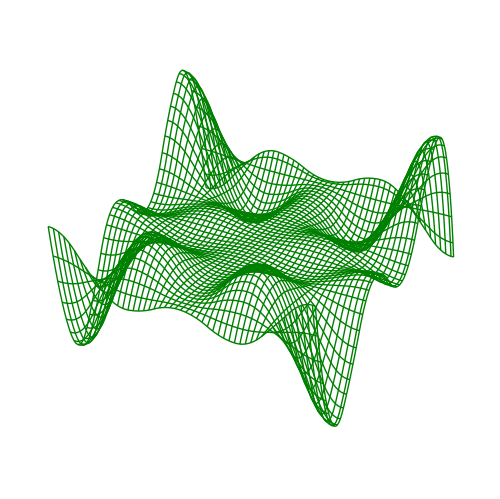

In [6]:
out = np.array(Evaluate_JAX(ctrl_pts, Jm, PHI, segment_ids, num_pts))
fitplot = THB_plot('surfaces/xysincos', 'final_surface')
fitplot.add_3Daxis('final surface')
fitplot.plot_3D_wireframe_surface('final surface', out, (100, 100))